# Import libs

In [86]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from PIL import Image

sys.path.append('.')

from MODNet.src.models.modnet import MODNet

import AdaIN.net as net
from AdaIN.function import adaptive_instance_normalization, coral

In [87]:
device = torch.device("cuda:7" if torch.cuda.is_available() else 'cpu')

# Read content image and style image

In [88]:
start_time = time.time()

In [89]:
content_img = Image.open("Images/Content_images/1.jpg") #TODO 
style_img = Image.open("Images/Style_images/scream.jpg") #TODO 

# Run Modnet to get alpha matte

In [90]:
# define hyper-parameters
ref_size = 512 #TODO 

# define image to tensor transform
im_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

# create MODNet and load the pre-trained ckpt
ckpt_path = "./MODNet/pretrained/modnet_photographic_portrait_matting.ckpt"

modnet = MODNet(backbone_pretrained=False)
modnet = nn.DataParallel(modnet)
modnet.to(device)

checkpoint = torch.load(ckpt_path, map_location=device)
modnet.load_state_dict(torch.load(ckpt_path, map_location=device))
modnet = modnet.module
modnet.eval() 

MODNet(
  (backbone): MobileNetV2Backbone(
    (model): MobileNetV2(
      (features): Sequential(
        (0): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
            (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
     

In [91]:
# unify image channels to 3
im = np.asarray(content_img)

if len(im.shape) == 2:
    im = im[:, :, None]
if im.shape[2] == 1:
    im = np.repeat(im, 3, axis=2)
elif im.shape[2] == 4:
    im = im[:, :, 0:3]

# convert image to PyTorch tensor
im = Image.fromarray(im)
im = im_transform(im)

# add mini-batch dim
im = im[None, :, :, :]

# resize image for input
im_b, im_c, im_h, im_w = im.shape
if max(im_h, im_w) < ref_size or min(im_h, im_w) > ref_size:
    if im_w >= im_h:
        im_rh = ref_size
        im_rw = int(im_w / im_h * ref_size)
    elif im_w < im_h:
        im_rw = ref_size
        im_rh = int(im_h / im_w * ref_size)
else:
    im_rh = im_h
    im_rw = im_w

im_rw = im_rw - im_rw % 32
im_rh = im_rh - im_rh % 32
im = F.interpolate(im, size=(im_rh, im_rw), mode='area')

# inference
_, _, matte = modnet(im.to(device) if torch.cuda.is_available() else im, True)

# resize and save matte
matte = F.interpolate(matte, size=(im_h, im_w), mode='area')
matte = matte[0][0].data.cpu().numpy()

# Run AdaIN to get restyled image

In [92]:
def test_transform(size, crop):
    transform_list = []
    if size != 0:
        transform_list.append(transforms.Resize(size))
    if crop:
        transform_list.append(transforms.CenterCrop(size))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform


def style_transfer(vgg, decoder, content, style, alpha=1.0,
                   interpolation_weights=None):
    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    style_f = vgg(style)
    if interpolation_weights:
        _, C, H, W = content_f.size()
        feat = torch.FloatTensor(1, C, H, W).zero_().to(device)
        base_feat = adaptive_instance_normalization(content_f, style_f)
        for i, w in enumerate(interpolation_weights):
            feat = feat + w * base_feat[i:i + 1]
        content_f = content_f[0:1]
    else:
        feat = adaptive_instance_normalization(content_f, style_f)
    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)

In [93]:
content_img = Image.open("Images/Content_images/1.jpg") #TODO 
style_img = Image.open("Images/Style_images/scream.jpg") #TODO 

In [94]:
decoder = net.decoder
vgg = net.vgg

decoder.eval()
vgg.eval()

decoder.load_state_dict(torch.load("./AdaIN/models/decoder.pth"))
vgg.load_state_dict(torch.load("./AdaIN/models/vgg_normalised.pth"))
vgg = nn.Sequential(*list(vgg.children())[:31])

vgg.to(device)
decoder.to(device)

content_tf = test_transform(size=512, crop=False)
style_tf = test_transform(size=512, crop=False)

content = content_tf(content_img)
style = style_tf(style_img)
style = style.to(device).unsqueeze(0)
content = content.to(device).unsqueeze(0)
with torch.no_grad():
    output = style_transfer(vgg, decoder, content, style, alpha=1.0)

output = F.interpolate(output, size=(im_h, im_w), mode='area')
output = output.permute(0, 2, 3, 1)
output = output[0].data.cpu().numpy()
output = np.clip(output, 0, 1)  
output = (output * 255).astype(np.uint8)

# Post processing

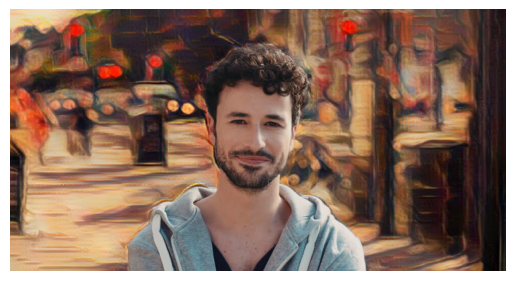

In [95]:
final_image = np.array(content_img) * np.expand_dims(matte, axis=2) / 255.0 + output * (1 - np.expand_dims(matte, axis=2)) / 255.0

plt.imshow(final_image)
plt.axis('off')
plt.show()

In [96]:
print("Total_time:", time.time() - start_time)

Total_time: 0.8392195701599121


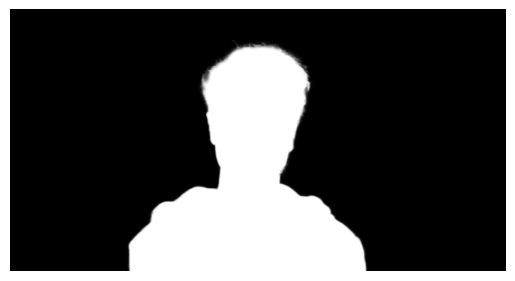

In [97]:
plt.imshow(matte, cmap='gray')
plt.axis('off')
plt.show()

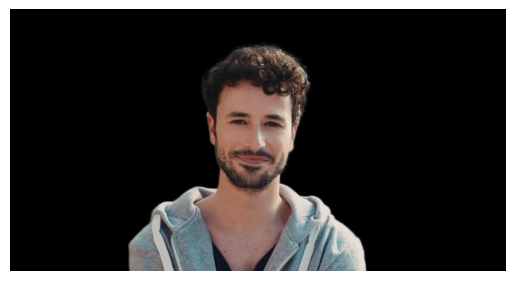

In [98]:
plt.imshow(np.array(content_img) * np.expand_dims(matte, axis=2) / 255.0, cmap='gray')
plt.axis('off')
plt.show()

# Show mask difference

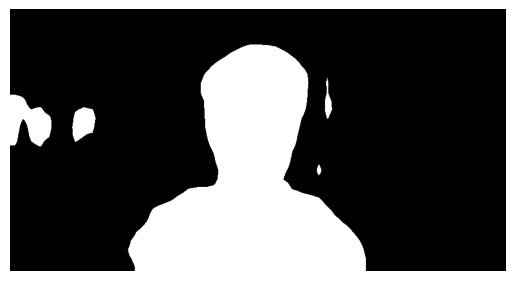

In [101]:
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(
    pretrained=True,  # pretrained trên COCO VOC
    progress=True
)
model.eval()

image_path = "your_image.jpg"
img = content_img
orig_w, orig_h = img.size

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

input_tensor = transform(img).unsqueeze(0)  # shape: (1, 3, H, W)

with torch.no_grad():
    output = model(input_tensor)['out']  # shape: (1, num_classes, H_out, W_out)

pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()  # shape: (H_out, W_out)

# --------------------------
# 6. Lấy nhãn người (person label = 15)
# --------------------------
person_mask = (pred_mask == 15).astype(np.uint8)  # 1 nếu người, 0 nếu background

# --------------------------
# 7. Resize mask về ảnh gốc
# --------------------------
mask_resized = Image.fromarray(person_mask*255)  # *255 để thành 0-255
mask_resized = mask_resized.resize((orig_w, orig_h), resample=Image.NEAREST)
mask_resized = np.array(mask_resized)  # (H, W), 0 = background, 255 = person

# --------------------------
# 8. Hiển thị mask
# --------------------------
plt.imshow(mask_resized, cmap='gray')
plt.axis('off')
plt.show()